In [27]:
library(MASS)
library(car)
library(caret)
data <- read.csv("BodyFat.csv")

## Processing

In [6]:
find_iqr_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR_value
  upper_bound <- Q3 + 1.5 * IQR_value
  x < lower_bound | x > upper_bound
}

# 使用其他变量名
body_fat_data <- read.csv("BodyFat.csv")

# 将代码中的所有 "data" 替换为 "body_fat_data"
data_no_id <- body_fat_data[ , !(names(body_fat_data) %in% c("IDNO"))]
iqr_outliers_flags <- as.data.frame(lapply(data_no_id, find_iqr_outliers))
outliers_original <- body_fat_data[apply(iqr_outliers_flags, 1, any), ]
outliers_columns <- apply(iqr_outliers_flags[apply(iqr_outliers_flags, 1, any), ], 1, function(x) {
  colnames(data_no_id)[x]
})
outliers_original$Outlier_Variables <- sapply(outliers_columns, paste, collapse = ", ")
print(outliers_original)


    IDNO BODYFAT DENSITY AGE WEIGHT HEIGHT ADIPOSITY NECK CHEST ABDOMEN   HIP
31    31    12.3  1.0716  32 182.00  73.75      23.6 38.7 100.5    88.7  99.8
35    35    31.1  1.0263  41 247.25  73.50      32.2 42.1 117.0   115.6 116.1
39    39    33.8  1.0202  46 363.15  72.25      48.9 51.2 136.2   148.1 147.7
41    41    33.1  1.0217  45 262.75  68.75      39.1 43.2 128.3   126.2 125.6
42    42    31.7  1.0250  44 205.00  29.50      29.9 36.6 106.0   104.3 115.5
45    45     8.4  1.0814  39 125.25  68.00      19.1 31.5  85.1    76.0  88.2
86    86    25.8  1.0386  67 167.00  67.50      26.0 36.5  98.9    89.7  96.2
106  106    17.8  1.0578  43 165.50  68.50      24.8 31.1  93.1    87.3  96.6
152  152    19.1  1.0542  26 241.75  74.50      30.7 41.8 108.3   102.9 114.4
159  159    12.8  1.0704  30 136.50  68.75      20.3 35.9  88.7    76.6  89.8
169  169    34.7  1.0180  35 228.25  69.50      33.3 40.4 114.9   115.9 111.9
175  175    24.6  1.0414  36 226.75  71.75      31.0 41.5 115.3 

In [8]:
body_fat_data <- body_fat_data[!(body_fat_data$IDNO %in% c(39, 41, 216)), ]


In [9]:
body_fat_data$HEIGHT <-round(body_fat_data$HEIGHT * 2.54 , 2)
weight_kg <- body_fat_data$WEIGHT[42] * 0.453592  
height_m <- sqrt(weight_kg / body_fat_data$ADIPOSITY[42])  
height_cm <- round(height_m * 100, 2)  
body_fat_data$HEIGHT[42] <- height_cm
body_fat_data[body_fat_data$IDNO == 42, ]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42,42,31.7,1.025,44,205,74.93,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


In [11]:
#Preprocessed data
df <- body_fat_data[, !names(data) %in% c("IDNO", "DENSITY")]
df_scaled <- as.data.frame(scale(df))
write.csv(df_scaled, "data.csv", row.names = FALSE)

## Stepwise Regression

In [17]:
d <- read.csv("data.csv")
dim(d)
full_model <- lm(BODYFAT ~ ., data = d)
model1 <- stepAIC(full_model, direction = "both", trace = FALSE)
summary(model1)
adjusted_r_squared1 <- round(summary(model1)$adj.r.squared,3)

[1] 249  15


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + 
    FOREARM + WRIST, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7112 -2.7272 -0.2259  2.6502  9.3716 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -29.33016    8.35770  -3.509 0.000536 ***
AGE           0.06812    0.02859   2.383 0.017959 *  
WEIGHT       -0.08891    0.03246  -2.739 0.006616 ** 
NECK         -0.32208    0.20465  -1.574 0.116847    
ABDOMEN       0.81452    0.06668  12.215  < 2e-16 ***
THIGH         0.23141    0.10694   2.164 0.031455 *  
FOREARM       0.36390    0.18005   2.021 0.044373 *  
WRIST        -1.43551    0.47741  -3.007 0.002919 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.921 on 241 degrees of freedom
Multiple R-squared:  0.7345,	Adjusted R-squared:  0.7268 
F-statistic: 95.27 on 7 and 241 DF,  p-value: < 2.2e-16


## Simple Linear Regression

In [18]:
variables <- colnames(d)
variables <- variables[variables != "BODYFAT"]

max_adjusted_r_squared <- 0 
best_variable <- ""
for (var in variables) {
  formula <- as.formula(paste("BODYFAT ~", var))
  model <- lm(formula, data = d)
  adjusted_r_squared <- summary(model)$adj.r.squared
  if (adjusted_r_squared > max_adjusted_r_squared) {
    max_adjusted_r_squared <- adjusted_r_squared
    best_variable <- var
  }
}

best_formula <- as.formula(paste("BODYFAT ~", best_variable))
model2 <- lm(best_formula, data = d)
adjusted_r_squared2 <- round(max_adjusted_r_squared, 3)

In [19]:
best_formula

BODYFAT ~ ABDOMEN

## Two variable linear regression

In [20]:
max_adjusted_r_squared <- 0
best_variable_pair <- c("","")


for (i in 1:(length(variables) - 1)) {
  for (j in (i + 1):length(variables)) {
    var1 <- variables[i]
    var2 <- variables[j]
    formula <- as.formula(paste("BODYFAT ~", var1, "+", var2))
    model <- lm(formula, data = d)

    adjusted_r_squared <- summary(model)$adj.r.squared

    if (adjusted_r_squared > max_adjusted_r_squared) {
      max_adjusted_r_squared <- adjusted_r_squared
      best_variable_pair <- c(var1, var2)
    }
  }
}

best_formula <- as.formula(paste("BODYFAT ~", best_variable_pair[1], "+", best_variable_pair[2]))
model3 <- lm(best_formula, data = d)
adjusted_r_squared3 <- round(max_adjusted_r_squared, 3)

## Bivariate product term

In [21]:
max_adjusted_r_squared <- 0
best_variable_pair <- c("","")

for (i in 1:(length(variables) - 1)) {
  for (j in (i + 1):length(variables)) {
    var1 <- variables[i]
    var2 <- variables[j]
    d$interaction_term <- d[[var1]] * d[[var2]]
    formula <- as.formula("BODYFAT ~ interaction_term")
    model <- lm(formula, data = d)
    adjusted_r_squared <- summary(model)$adj.r.squared
    if (adjusted_r_squared > max_adjusted_r_squared) {
      max_adjusted_r_squared <- adjusted_r_squared
      best_variable_pair <- c(var1, var2)
    }
  }
}


d$best_interaction_term <- d[[best_variable_pair[1]]] * d[[best_variable_pair[2]]]
best_formula <- as.formula("BODYFAT ~ best_interaction_term")
model4 <- lm(best_formula, data = d)
adjusted_r_squared4 <- round(max_adjusted_r_squared, 3)

Notice that all the best model includes the variable ABDOMEN, so try its higher-order terms.


## ABDOMEN^2

In [22]:
d$ABDOMEN_squared <- d$ABDOMEN^2
model5 <- lm(BODYFAT ~ ABDOMEN_squared, data = d)
adjusted_r_squared5 <- round(summary(model5)$adj.r.squared, 3)

## ABDOMEN^2 + other 1-order

In [23]:
variables <- variables[!variables %in% c("BODYFAT", "ABDOMEN", "ABDOMEN_squared")]

max_adjusted_r_squared <- 0
best_variable <- ""

for (var in variables) {
  formula <- as.formula(paste("BODYFAT ~ ABDOMEN_squared +", var))
  model <- lm(formula, data = d)
  adjusted_r_squared <- summary(model)$adj.r.squared
  if (adjusted_r_squared > max_adjusted_r_squared) {
    max_adjusted_r_squared <- adjusted_r_squared
    best_variable <- var
  }
}

best_formula <- as.formula(paste("BODYFAT ~ ABDOMEN_squared +", best_variable))
model6 <- lm(best_formula, data = d)
adjusted_r_squared6 <- round(max_adjusted_r_squared, 3)

## ABDOMEN^2 +ABDOMEN +other variable 1-order

In [24]:
max_adjusted_r_squared <- 0
best_variable <- ""
for (var in variables) {
 
  formula <- as.formula(paste("BODYFAT ~ ABDOMEN + ABDOMEN_squared +", var))
  model <- lm(formula, data = d)
  adjusted_r_squared <- summary(model)$adj.r.squared
  if (adjusted_r_squared > max_adjusted_r_squared) {
    max_adjusted_r_squared <- adjusted_r_squared
    best_variable <- var
  }
}

best_formula <- as.formula(paste("BODYFAT ~ ABDOMEN + ABDOMEN_squared +", best_variable))
model7 <- lm(best_formula, data = d)
adjusted_r_squared7 <- round(max_adjusted_r_squared, 3)

## 10-fold CV

In [28]:
train_control <- trainControl(method = "cv", number = 10)
mse_results <- c()

for (i in 1:7) {
  model <- get(paste0("model", i))
  cv_model <- train(
    formula(model),
    data = d,  
    method = "lm",  
    trControl = train_control,  
    metric = "RMSE"  
  )
  mse_results <- c(mse_results, mean((cv_model$results$RMSE)^2))
}

In [29]:
model_names <- c(
  "BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + FOREARM + WRIST",  
  "BODYFAT ~ ABDOMEN ",  
  "BODYFAT ~ WEIGHT + ABDOMEN",  
  "BODYFAT ~ ABDOMEN * WEIGHT",  
  "BODYFAT ~ ABDOMEN_squared", 
  "BODYFAT ~ ABDOMEN_squared + WEIGHT",  
  "BODYFAT ~ ABDOMEN + ABDOMEN_squared + WEIGHT"  
)
mse_results <- round(mse_results, 3)

results_df <- data.frame(
  model = model_names,
  adjusted_R_squared = c(adjusted_r_squared1, adjusted_r_squared2, adjusted_r_squared3, adjusted_r_squared4, adjusted_r_squared5, adjusted_r_squared6, adjusted_r_squared7),
  MSE = mse_results
)

In [30]:
results_df

model,adjusted_R_squared,MSE
<chr>,<dbl>,<dbl>
BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + FOREARM + WRIST,0.727,15.632
BODYFAT ~ ABDOMEN,0.666,18.760
BODYFAT ~ WEIGHT + ABDOMEN,0.708,16.341
BODYFAT ~ ABDOMEN * WEIGHT,0.615,21.505
BODYFAT ~ ABDOMEN_squared,0.659,18.806
BODYFAT ~ ABDOMEN_squared + WEIGHT,0.696,17.223
BODYFAT ~ ABDOMEN + ABDOMEN_squared + WEIGHT,0.709,16.439


In [31]:
write.csv(d, "data_new.csv", row.names = FALSE)

In [32]:
write.csv(results_df, "results.csv", row.names = FALSE)

##  Model Compare

1, Accuracy Retention in Noisy Data
$$
Retention Rate=1 - \frac{|metric_{noisy} - metric_{original}|}{metric_{original}}
$$
metric = MSE

In [33]:
dn <- read.csv("data_new.csv")
model_names <- c(
  "BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + FOREARM + WRIST",  
  "BODYFAT ~ ABDOMEN ",  
  "BODYFAT ~ WEIGHT + ABDOMEN",  
  "BODYFAT ~ ABDOMEN * WEIGHT",  
  "BODYFAT ~ ABDOMEN_squared", 
  "BODYFAT ~ ABDOMEN_squared + WEIGHT",  
  "BODYFAT ~ ABDOMEN + ABDOMEN_squared + WEIGHT"  
)

add_noise <- function(y, noise_level = 0.1) {
    noise_sd = sd(y)
    return(y + rnorm(length(y), mean = 0, sd = (noise_level* noise_sd)  ))
}

metric <- function(predictions, actual) {
  return(mean((predictions - actual)^2))
}

In [34]:
folds <- createFolds(dn$BODYFAT, k = 10, list = TRUE)
mse_list <- matrix(0, nrow = 10, ncol = 7)
mse_list_noisy <- matrix(0, nrow = 10, ncol = 7)
for(i in 1:10) {
  test_index <- folds[[i]]
  trainset <- dn[-test_index,]
  testset <- dn[test_index,]
  trainset_noisy <- as.data.frame(lapply(trainset,add_noise))
  for (j in 1:7) {
      model_formula <- model_names[j]
      model <- lm(as.formula(model_formula), data = trainset)
      predictions <- predict(model, newdata = testset)
      mse <- metric(predictions, testset$BODYFAT)
      mse_list[i,j]<-mse

      model_noisy <- lm(as.formula(model_formula), data = trainset_noisy)
      predictions_noisy <- predict(model_noisy, newdata = testset)
      mse_noisy <- metric(predictions_noisy, testset$BODYFAT)
      mse_list_noisy[i,j]<-mse_noisy
  }
}
average_mse <- colMeans(mse_list)
average_mse_noisy <- colMeans(mse_list_noisy)
retention_rate <- 1 - abs(average_mse_noisy - average_mse) / average_mse

In [35]:
results_df = read.csv("results.csv")
results_df$retention_MSE_rate = retention_rate
results_df$num_predictors = c(7, 1, 2, 1, 1, 2, 2)
results_df

model,adjusted_R_squared,MSE,retention_MSE_rate,num_predictors
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + FOREARM + WRIST,0.727,15.632,0.9950861,7
BODYFAT ~ ABDOMEN,0.666,18.760,0.9980324,1
BODYFAT ~ WEIGHT + ABDOMEN,0.708,16.341,0.9981718,2
BODYFAT ~ ABDOMEN * WEIGHT,0.615,21.505,0.9991299,1
BODYFAT ~ ABDOMEN_squared,0.659,18.806,0.9990679,1
BODYFAT ~ ABDOMEN_squared + WEIGHT,0.696,17.223,0.9986232,2
BODYFAT ~ ABDOMEN + ABDOMEN_squared + WEIGHT,0.709,16.439,0.9966941,2


## Model Diagnostics

In [36]:
library(ggplot2)

In [37]:
dn <- read.csv("data_new.csv")
model_names <- c(
  "BODYFAT ~ AGE + WEIGHT + NECK + ABDOMEN + THIGH + FOREARM + WRIST",  
  "BODYFAT ~ ABDOMEN ",  
  "BODYFAT ~ WEIGHT + ABDOMEN",  
  "BODYFAT ~ ABDOMEN * WEIGHT",  
  "BODYFAT ~ ABDOMEN_squared", 
  "BODYFAT ~ ABDOMEN_squared + WEIGHT",  
  "BODYFAT ~ ABDOMEN + ABDOMEN_squared + WEIGHT"  
)


### res plot

png 
  2

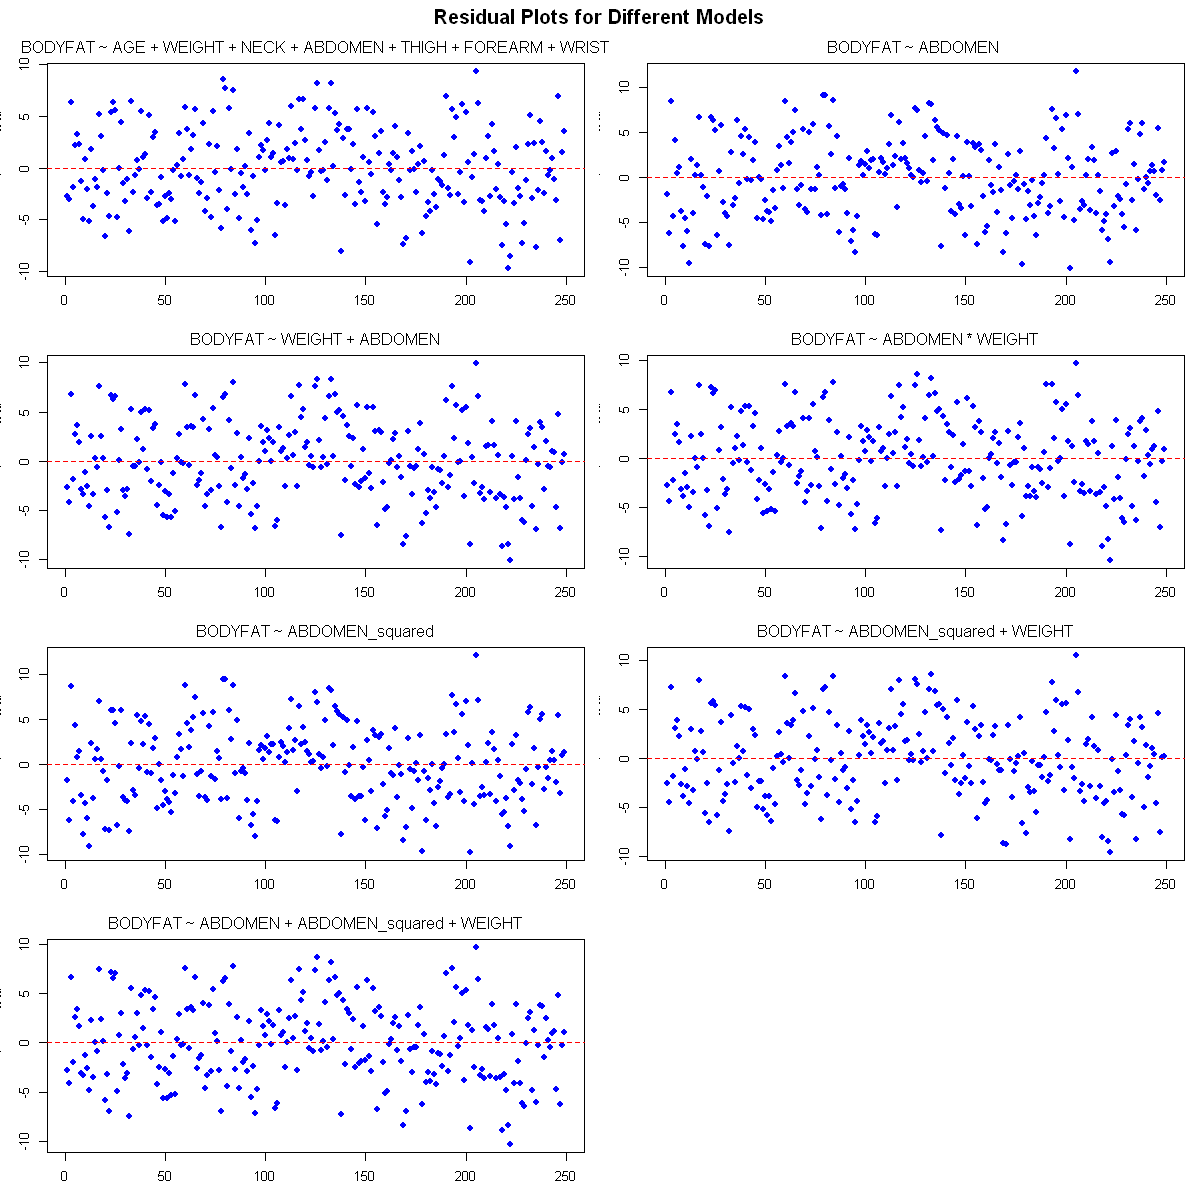

In [38]:
models <- list()
for (i in 1:length(model_names)) {
  models[[i]] <- lm(as.formula(model_names[i]), data = dn)
}
png("Residual_Plots.png", width = 1000, height = 1000)  
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow = c(4, 2), mar = c(3, 3, 2, 1), oma = c(0, 0, 2, 0))
for (i in 1:length(models)) {
  plot(residuals(models[[i]]),   col = "blue", pch = 19)
  abline(h = 0, col = "red", lty = 2)
     mtext(model_names[i], side = 3, line = 0.5, cex = 0.8)  
}
title("Residual Plots for Different Models", outer = TRUE, cex.main = 1.5)
dev.off()

par(mfrow = c(4, 2), mar = c(3, 3, 2, 1), oma = c(0, 0, 2, 0))
for (i in 1:length(models)) {
  plot(residuals(models[[i]]),   col = "blue", pch = 19)
  abline(h = 0, col = "red", lty = 2)
     mtext(model_names[i], side = 3, line = 0.5, cex = 0.8)  
}
title("Residual Plots for Different Models", outer = TRUE, cex.main = 1.5)

### QQ plot

png 
  2

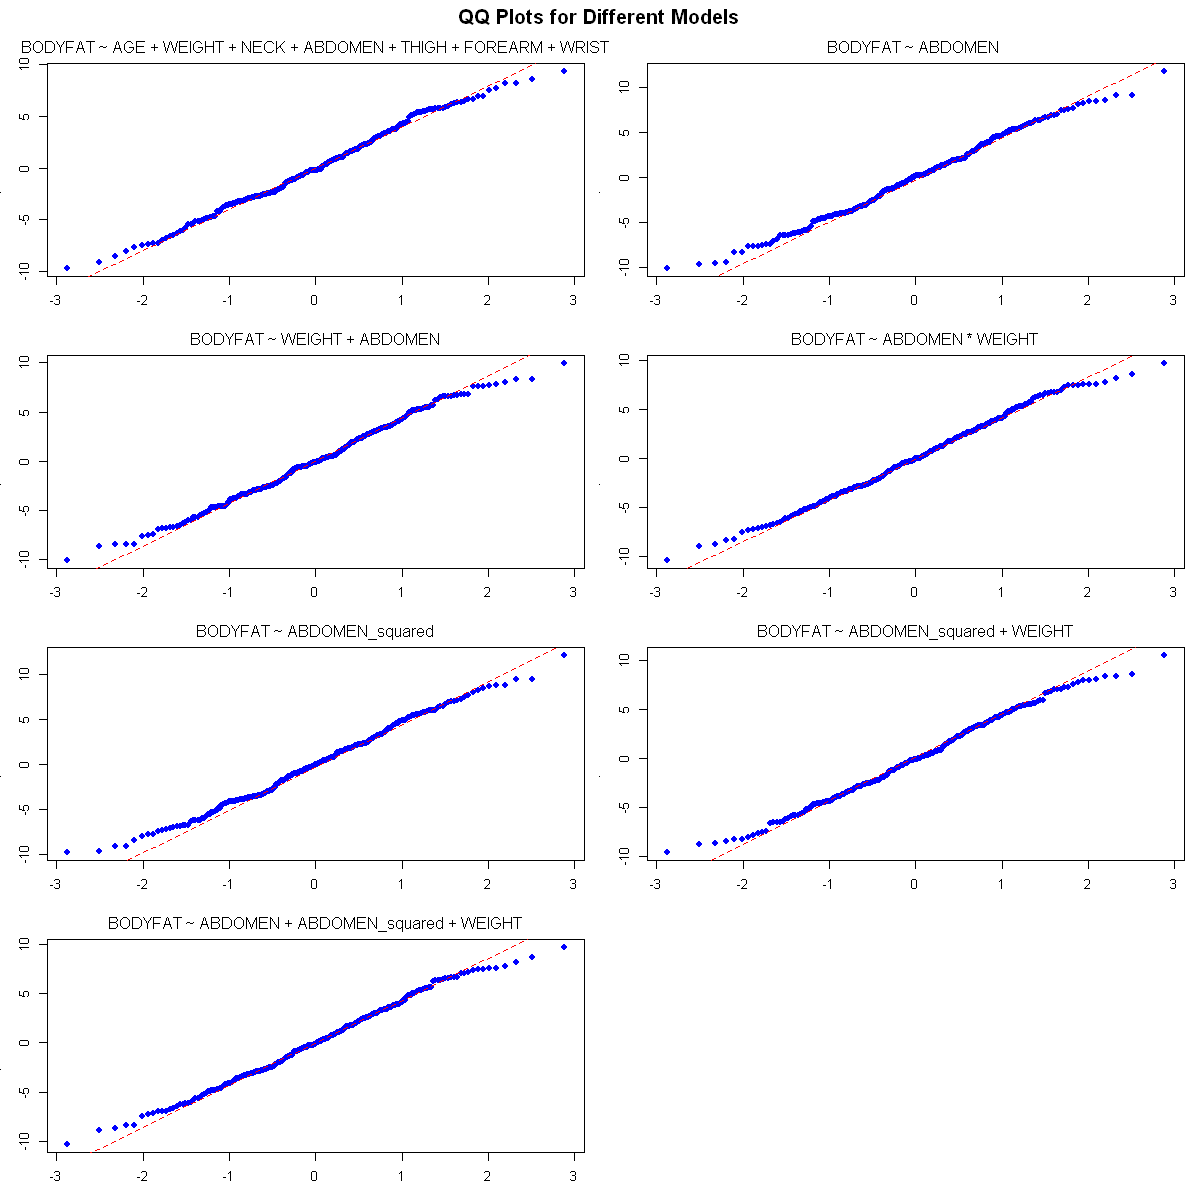

In [39]:
png("QQ_Plots.png", width = 1000, height = 1000)  # 指定保存为png，设置尺寸
par(mfrow = c(4, 2), mar = c(3, 3, 2, 1), oma = c(0, 0, 2, 0))
for (i in 1:length(models)) {
  qqnorm(residuals(models[[i]]), main = '', col = "blue", pch = 19)
  qqline(residuals(models[[i]]), col = "red", lty = 2)
    mtext(model_names[i], side = 3, line = 0.5, cex = 0.8)  
}
title("QQ Plots for Different Models", outer = TRUE, cex.main = 1.5)
dev.off()
par(mfrow = c(4, 2), mar = c(3, 3, 2, 1), oma = c(0, 0, 2, 0))
for (i in 1:length(models)) {
  qqnorm(residuals(models[[i]]), main = '', col = "blue", pch = 19)
  qqline(residuals(models[[i]]), col = "red", lty = 2)
    mtext(model_names[i], side = 3, line = 0.5, cex = 0.8)  
}
title("QQ Plots for Different Models", outer = TRUE, cex.main = 1.5)